# Autoencoder-Based Outlier Detection

In [2]:
import sys
print(f"Python path: {sys.executable}")
print(f"Looking for packages in these directories: {sys.path}")

import torch
# Pytorch check
print(f"Is CUDA working? {torch.cuda.is_available()}")
print(f"Using this GPU: {torch.cuda.get_device_name(0)}")

import os
import random

import h5py
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sympy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Python path: /users/jzhu118/.conda/envs/GEDI/bin/python
Looking for packages in these directories: ['/oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR', '/users/jzhu118/.conda/envs/GEDI/lib/python313.zip', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13/lib-dynload', '', '/users/jzhu118/.local/lib/python3.13/site-packages', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages']
Is CUDA working? True
Using this GPU: Quadro RTX 6000


## Step 1: Load the data

In [3]:
from torch.utils.data import Dataset, DataLoader

'''Load df from a .parquet file'''

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is {device}")

df = pd.read_parquet('input_standard_scaled.parquet', engine='pyarrow')
print(f'Dataset has shape {df.shape}')

# 3) Shuffle data (optional, but often useful for large sets)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Data shuffled")

# 4) Train-test split (for validation or test purposes)
#    Let's hold out 30% for a test set
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print("Train-test-split")

train_data = train_df.to_numpy().astype(np.float32)
test_data = test_df.to_numpy().astype(np.float32)
print("Data converted to NumPy arrays and float32 for Pytorch")

print(f"train_data shape: {train_data.shape}")
print(f"test_data shape: {test_data.shape}")

Device is cuda
Dataset has shape (11607187, 85)
Data shuffled
Train-test-split
Data converted to NumPy arrays and float32 for Pytorch
train_data shape: (8125030, 85)
test_data shape: (3482157, 85)


In [4]:
class TabularDataset(Dataset):
    def __init__(self, data_array):
        # data_array: NumPy array shape (N, 85)
        self.X = data_array
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # returns a single sample (as a torch float tensor)
        sample = self.X[idx, :]
        return torch.from_numpy(sample)

# Instantiate Datasets
train_dataset = TabularDataset(train_data)
test_dataset  = TabularDataset(test_data)

# Create DataLoaders
# choose a batch_size that fits in VRAM
batch_size = 2048
print(f"Using batch size {batch_size}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print ("Data processing complete")

Using batch size 2048
Data processing complete


## Step 2: Set up the autoencoder
The autoencoder has 5 encoding layers and 5 decoding layers. All activation layers between these layers are ReLU.

In [5]:
import torch.nn as nn
import torch.optim as optim
'''
We've determined empirically that there are 85 relevant features in the input data (after dropping invalid and non-numeric features like ShotNum)
'''
class Autoencoder(nn.Module):
    def __init__(self, input_dim=85, latent_dim=16, dropout_p=0.2):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, latent_dim),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            # no activation here, often we let the raw linear output be
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent  # Return latent if you want to apply additional losses

## Step 3: Set up learning and loss function
We will define our loss function to be mean-squared error (MSE) and use the Adam optimizer.

In [7]:
model = Autoencoder(input_dim=85, latent_dim=13, dropout_p=0.1)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
print("Model, loss function, optimizer defined.")

Let's use 2 GPUs!
Model, loss function, optimizer defined.


## Step 4: Main training loop
The loss of each epoch is captured in a Pandas dataframe *loss_df* for convenient graphing.

In [8]:
num_epochs = 20  # Adjust based on time constraints
loss_df = []

# Define your L1 weight hyperparameter (adjust as needed)
l1_weight = 7e-6

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    losses = []
    print(f"Starting epoch {epoch}")
    
    for batch_data in train_loader:
        # batch_data shape: (batch_size, 85)
        batch_data = batch_data.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass: assume model returns (reconstruction, latent)
        recon, latent = model(batch_data)
        
        # Compute reconstruction loss (e.g., MSE loss)
        loss = criterion(recon, batch_data)
        
        # Compute L1 penalty on latent activations
        l1_penalty = l1_weight * torch.norm(latent, 1)
        
        # Add L1 penalty to the loss
        loss += l1_penalty
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        losses.append(loss.detach().cpu().item())
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    
    loss_df.append({
        'epoch': epoch + 1,
        'loss': avg_loss
    })

print("Done training")
loss_df = pd.DataFrame(loss_df)
loss_df.index = loss_df['epoch']
loss_df = loss_df.drop(columns=['epoch'])

Starting epoch 0


/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch [1/20], Loss: 0.259646
Starting epoch 1
Epoch [2/20], Loss: 0.178962
Starting epoch 2
Epoch [3/20], Loss: 0.155157
Starting epoch 3
Epoch [4/20], Loss: 0.143187
Starting epoch 4
Epoch [5/20], Loss: 0.136858
Starting epoch 5
Epoch [6/20], Loss: 0.132851
Starting epoch 6
Epoch [7/20], Loss: 0.121904
Starting epoch 7
Epoch [8/20], Loss: 0.117011
Starting epoch 8
Epoch [9/20], Loss: 0.115703
Starting epoch 9
Epoch [10/20], Loss: 0.113830
Starting epoch 10
Epoch [11/20], Loss: 0.109868
Starting epoch 11
Epoch [12/20], Loss: 0.108128
Starting epoch 12
Epoch [13/20], Loss: 0.107158
Starting epoch 13
Epoch [14/20], Loss: 0.107300
Starting epoch 14
Epoch [15/20], Loss: 0.106102
Starting epoch 15
Epoch [16/20], Loss: 0.106732
Starting epoch 16
Epoch [17/20], Loss: 0.104881
Starting epoch 17
Epoch [18/20], Loss: 0.104168
Starting epoch 18
Epoch [19/20], Loss: 0.100789
Starting epoch 19
Epoch [20/20], Loss: 0.101663
Done training


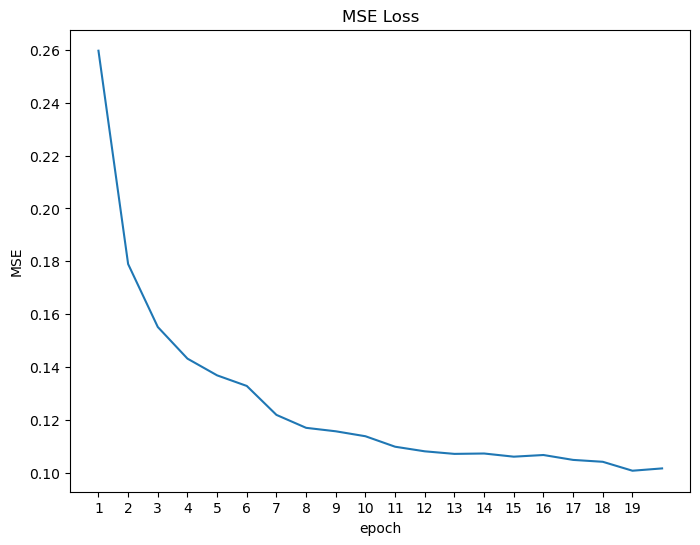

In [9]:
plt.figure(figsize=(8,6))
ax = loss_df['loss'].plot(kind='line', title='MSE Loss', ylabel='MSE')
_ = ax.set_xticks(list(range(1, num_epochs, 1)))

## Step 5: Compute reconstruction error and determine the outlier threshold

In [10]:
model.eval()
train_losses = []
batch_count = 1
with torch.no_grad():
    for batch_data in train_loader:
        print(f"Processing batch {batch_count}")
        batch_data = batch_data.to(device)
        recon, latent = model(batch_data)
        
        # MSE per sample
        mse = torch.mean((recon - batch_data)**2, dim=1)  # shape: (batch_size,)
        train_losses.append(mse.cpu().numpy())

        batch_count += 1

train_losses = np.concatenate(train_losses, axis=0)  # shape (num_train_samples,)
print("Train losses shape:", train_losses.shape)

# e.g., compute some stats
mean_loss = np.mean(train_losses)
std_loss  = np.std(train_losses)
print(f"Train MSE mean: {mean_loss:.6f}, std: {std_loss:.6f}")

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing batch 50
Processin

In [14]:
threshold = np.percentile(train_losses, 97)
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 0.13430507


In [15]:
test_losses = []
batch_count = 1
with torch.no_grad():
    for batch_data in test_loader:
        print(f"Processing batch {batch_count}")
        batch_data = batch_data.to(device)
        recon, latent = model(batch_data)
        mse = torch.mean((recon - batch_data)**2, dim=1)
        test_losses.append(mse.cpu().numpy())
        batch_count += 1

test_losses = np.concatenate(test_losses, axis=0)
print("Test losses shape:", test_losses.shape)

# Label outliers
outliers_test = (test_losses > threshold).astype(int)  # 1 for outlier, 0 for inlier

# Check fraction of outliers, this should be similar to the previously chosen threshold
outlier_fraction = np.mean(outliers_test)
print(f"Outlier fraction in test set: {outlier_fraction:.2%}")

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
Processing batch 34
Processing batch 35
Processing batch 36
Processing batch 37
Processing batch 38
Processing batch 39
Processing batch 40
Processing batch 41
Processing batch 42
Processing batch 43
Processing batch 44
Processing batch 45
Processing batch 46
Processing batch 47
Processing batch 48
Processing batch 49
Processing batch 50
Processin

RH 50 index is 1, RH 95 index is 4


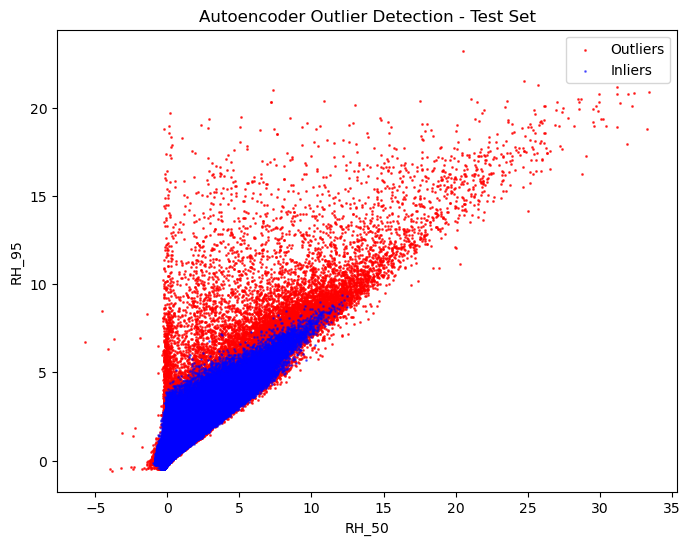

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose outliers_test is 1 for outlier, 0 for inlier
# test_data is shape (N_test, 92) (float32 or float64)
# We pick columns that correspond to RH_50 and RH_95 in the test set
rh_50_idx = test_df.columns.get_loc('RH_50')
rh_95_idx = test_df.columns.get_loc('RH_95')
print(f'RH 50 index is {rh_50_idx}, RH 95 index is {rh_95_idx}')

# Separate inliers vs outliers
inliers_mask  = (outliers_test == 0)
outliers_mask = (outliers_test == 1)

plt.figure(figsize=(8,6))

# Plot outliers
plt.scatter(
    test_data[outliers_mask, rh_50_idx],
    test_data[outliers_mask, rh_95_idx],
    color='red', s=1, alpha=0.7, label='Outliers'
)

# Plot inliers
plt.scatter(
    test_data[inliers_mask, rh_50_idx],
    test_data[inliers_mask, rh_95_idx],
    color='blue', s=1, alpha=0.5, label='Inliers'
)

plt.xlabel("RH_50")   # Or the actual name of the feature
plt.ylabel("RH_95")   # Or the actual name of the feature
plt.title("Autoencoder Outlier Detection - Test Set")
plt.legend()
plt.show()
